In [109]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import quantile_transform
from sklearn import metrics # for MAE, MSE

In [110]:
# Read the Data
data=pd.read_csv('Metro_Interstate_Traffic_Volume.csv', header=0)
data2=data.copy()

In [111]:
# Question 2.1. Explore the dataset with .describe()
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [112]:
# Question 2.1. Explore the dataset with .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [113]:
## Data Cleaning 
# convert Holiday to 1 and 0
def modify_holiday(x):
    if x == 'None':
        return 0
    else:
        return 1
data2['holiday'] = data2['holiday'].map(modify_holiday)
# change date_time variable to year, month, day, weekday, hour variables
data2['date_time'] = pd.to_datetime(data2.date_time)
data2['weekday'] = data2.date_time.dt.weekday
#data2['date'] = data2.date_time.dt.date
data2['hour'] = data2.date_time.dt.hour
data2['month'] = data2.date_time.dt.month
data2['year'] = data2.date_time.dt.year
#data2.set_index('date_time', inplace = True)
#creating dummy variables for variable weather_main, weekday, year, month
data2 = pd.get_dummies(columns=['weather_main'],data=data2)
data2 = pd.get_dummies(columns=['weekday'],data=data2)
data2 = pd.get_dummies(columns=['month'],data=data2)
data2 = pd.get_dummies(columns=['year'],data=data2)


In [114]:
# Remove outlier data from rain_1h and temp
data2 = data2.loc[data2.rain_1h<2000]
data2 = data2.loc[data2.temp>240]

In [115]:
# Question 2.1. Remove the unsuitable columns from the dataframe
data2=data2.drop(["weather_description","date_time", "snow_1h"],axis=1)

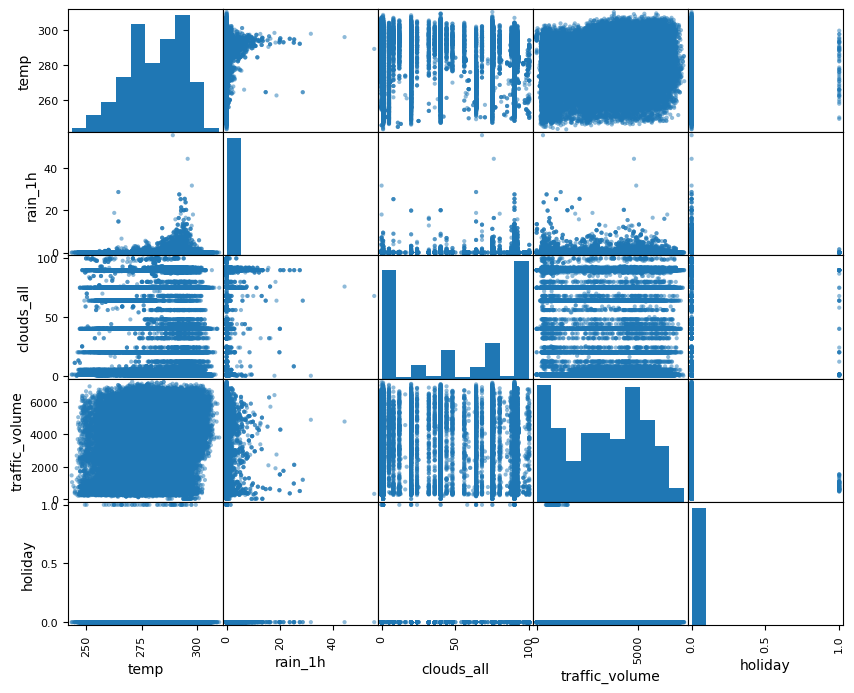

In [116]:
#Question 2-2. Plot the histogram
#Plotting relationship between temp, rain_1h, snow_1h, cloud_all.
num_vars = ['temp','rain_1h','clouds_all','traffic_volume', "holiday"]
scatter_matrix(data2[num_vars],figsize=(10,8))
plt.show()

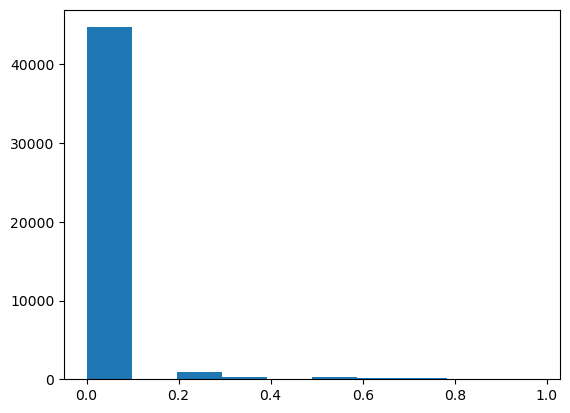

In [117]:
#Question 2-2.Plotting observations with values less than 1mm rain shows 
plt.hist(data2.rain_1h.loc[data2.rain_1h<1])
plt.show()

In [118]:
#Question 2-3. Split the dataset intro training and test sets
train_set, test_set=train_test_split(data2,test_size=0.3,random_state=42)
y_train=train_set["traffic_volume"]
x_train=train_set.drop(["traffic_volume"],axis=1)
y_test=test_set["traffic_volume"]
x_test=test_set.drop(["traffic_volume"],axis=1)

In [119]:
#Question 2-4.Apply a TransformedTargetRegressor
LinearRegression_with_trans_target = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=QuantileTransformer(n_quantiles=90, output_distribution="normal"),
).fit(x_train, y_train)
y_pred_LinearRegression_with_trans_target = LinearRegression_with_trans_target.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred_LinearRegression_with_trans_target))  
print('MSE:', mean_squared_error(y_test, y_pred_LinearRegression_with_trans_target))  

MAE: 1494.3991239117358
MSE: 3122997.1481973566


In [120]:
#Question 2-4.Apply a quantile_transform to Y_train
y_trans = quantile_transform(
    y_train.to_frame(), n_quantiles=90, output_distribution="normal", copy=True
).squeeze()

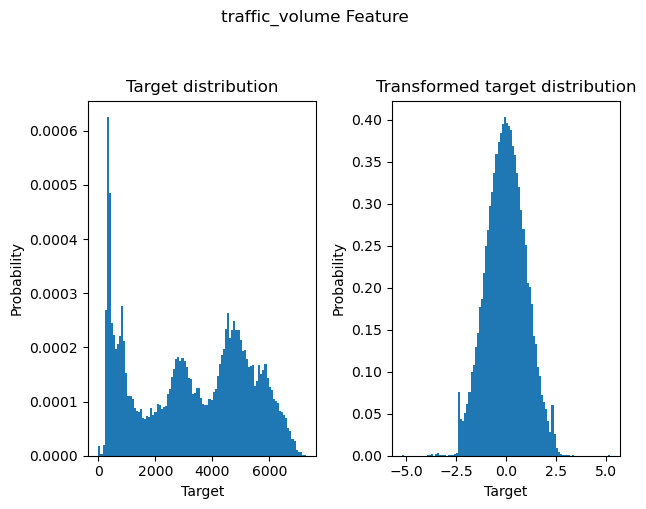

In [121]:
#Question 2-4.Plotting Y_train Besfore and After quantile_transform
f, (ax0, ax1) = plt.subplots(1, 2)
ax0.hist(y_train, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")
ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")
f.suptitle("traffic_volume Feature", y=1.05)
plt.tight_layout()

In [122]:
#Question 2-5.Train a simple linear regression model
LR=LinearRegression().fit(x_train, y_train)
y_pred_LinearRegression=LR.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred_LinearRegression))  
print('MSE:', mean_squared_error(y_test, y_pred_LinearRegression))  

MAE: 1562.1497655245332
MSE: 3179849.459128461


In [123]:
#Question 2-7.k-fold cross-validation with normal LinearRegression
# create a Linear Regression model
reg = LinearRegression()

# set up k-folds
k_values = [2, 5, 7, 10]
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=2023)
    cv_scores = []
    for m, n in kf.split(x_train):
        x_train_k, x_val = x_train.iloc[m], x_train.iloc[n]
        y_train_k, y_val = y_train.iloc[m], y_train.iloc[n]
        reg.fit(x_train_k, y_train_k)
        y_pred = reg.predict(x_test)
        cv_scores.append(mean_squared_error(y_test, y_pred))
    print("For k =", k, "the MSE is:", np.mean(cv_scores))

For k = 2 the MSE is: 1.0307810912702734e+20
For k = 5 the MSE is: 3180697.207638583
For k = 7 the MSE is: 3180380.936549607
For k = 10 the MSE is: 3180203.3596555484


In [96]:
#Question 2-8.k-fold cross-validation on Ridge
# create a Ridge model
from sklearn.linear_model import Ridge
rid = Ridge()

# set up k-folds
k_values = [2, 5, 7, 10]
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=2023)
    cv_scores = []
    for m, n in kf.split(x_train):
        x_train_k, x_val = x_train.iloc[m], x_train.iloc[n]
        y_train_k, y_val = y_train.iloc[m], y_train.iloc[n]
        rid.fit(x_train_k, y_train_k)
        y_pred = rid.predict(x_test)
        cv_scores.append(mean_squared_error(y_test, y_pred))
    print("For k =", k, "the MSE for Ridge is:", np.mean(cv_scores))
    print("For k =", k, "the Coef is:",rid.coef_)

For k = 2 the MSE for Ridge is: 3183236.1171154976
For k = 2 the Coef is: [-1397.09267138    36.65075367   -32.94852302     1.80267223
    89.9541969   -111.43468557   172.33853698   -95.62417544
  -298.91174159   181.33328006  -234.48648009  -161.29220376
  1243.1858586   -163.33428324     0.          -531.77410594
    26.27326723   268.41539443   329.82383862   395.36313239
   352.32412499  -485.89732211  -886.30243555   275.53964573
   479.58352305   349.30795451    33.51445467  -202.49047158
  -174.48881126  -588.25616083  -247.59709871  -338.4663837
    39.47414025    61.48893776   312.39027012   -56.75853965
    60.90218475    21.10092158   -57.63204863   -68.16072184
    65.3542336     35.1939702 ]
For k = 5 the MSE for Ridge is: 3180673.764608805
For k = 5 the Coef is: [-1426.77737839    36.59924321   -31.42738527     1.75458059
    89.59004733    11.47013804   281.66432543    11.60610132
   -71.46772076   321.13206686  -100.26153021     2.48462631
   672.16185076   -21.3777096

In [97]:
#Question 2-8.k-fold cross-validation on Lasso
# create a Lasso model
from sklearn.linear_model import Lasso
las = Lasso()

# set up k-folds
k_values = [2, 5, 7, 10]
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=2023)
    cv_scores = []
    for m, n in kf.split(x_train):
        x_train_k, x_val = x_train.iloc[m], x_train.iloc[n]
        y_train_k, y_val = y_train.iloc[m], y_train.iloc[n]
        las.fit(x_train_k, y_train_k)
        y_pred = las.predict(x_test)
        cv_scores.append(mean_squared_error(y_test, y_pred))
    print("For k =", k, "the MSE for Lasso is:", np.mean(cv_scores))
    print("For k =", k, "the Coef is:",las.coef_)

For k = 2 the MSE for Lasso is: 3183963.8759836336
For k = 2 the Coef is: [ -759.60020961    33.42511674   -34.43753451     1.76224097
    91.01687586    26.01167218   318.10751744    28.57011808
   -99.89547873   295.28274696   -75.24695374    -5.76269945
     0.            -0.             0.          -337.89713786
  -238.94812682     0.            52.67104694   116.95950114
    76.53073332  -746.34076646 -1147.88066706   186.856091
   395.95238206   289.15915547     0.          -191.60569097
  -148.18199811  -560.38824114  -225.10927743  -322.38959409
     0.             0.           215.01518224   -29.69570778
    36.24694384     0.           -55.97917715   -70.69101097
    50.29705821     9.27197007]
For k = 5 the MSE for Lasso is: 3182122.522035141
For k = 5 the Coef is: [-6.62386728e+02  3.34040069e+01 -3.27867243e+01  1.72573390e+00
  9.06594546e+01  9.94400469e-01  2.79374704e+02  0.00000000e+00
 -2.23242926e+01  2.86353916e+02 -8.97813777e+01  0.00000000e+00
  0.00000000e+00 -

In [98]:
#Question 2-8.k-fold cross-validation on Elastic net
# create a Elastic model
from sklearn.linear_model import ElasticNet
els = ElasticNet()

# set up k-folds
k_values = [2, 5, 7, 10]

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=2023)
    cv_scores = []
    for m, n in kf.split(x_train):
        x_train_k, x_val = x_train.iloc[m], x_train.iloc[n]
        y_train_k, y_val = y_train.iloc[m], y_train.iloc[n]
        els.fit(x_train_k, y_train_k)
        y_pred = els.predict(x_test)
        cv_scores.append(mean_squared_error(y_test, y_pred))
    print("For k =", k, "the MSE for ElasticNet is:", np.mean(cv_scores))
    print("For k =", k, "the Coef is:",els.coef_)

For k = 2 the MSE for ElasticNet is: 3336714.5004764833
For k = 2 the Coef is: [  -2.7245383    16.13631648  -43.59548143    2.82430804   95.26495313
  -10.78258817   90.33257705   -0.           -9.47564265   13.02096869
  -31.79304761  -19.17406528    0.           -8.65730597    0.
  -19.39258882    5.27371663   59.38984248   71.12144033   83.85955818
   77.53728338 -103.93285942 -196.24882087    0.           28.68944862
   28.25352126   -2.06679042   -2.87009526    8.70887975  -46.46233803
   -0.          -16.74635939    9.96637756   -3.14686989   -2.05550562
   -0.67422912    8.74842926    1.53312146  -14.79795133  -15.33783423
   18.62448804    0.90272623]
For k = 5 the MSE for ElasticNet is: 3336624.4337188923
For k = 5 the Coef is: [  -2.2635152    16.97229927  -42.31579946    2.80360501   94.6524507
  -12.1181375    82.47390574   -2.13355444   -5.86783765   12.82948753
  -31.82901251  -12.55831839    0.           -8.17056547   -0.
  -17.72448367    7.15314293   57.45336707   71.